# Used Car Price Prediction — Rusty Bargain

## Business Problem
Rusty Bargain is a used car dealership that wants to predict the market price of used vehicles based on their characteristics.  
The goal is to build a regression model that accurately estimates car prices to support pricing decisions.

## Data Loading


In [1]:
import pandas as pd
df = pd.read_csv('vehicles_us.csv')
df.head(), df.shape

(   price  model_year           model  condition  cylinders fuel  odometer  \
 0   9400      2011.0          bmw x5       good        6.0  gas  145000.0   
 1  25500         NaN      ford f-150       good        6.0  gas   88705.0   
 2   5500      2013.0  hyundai sonata   like new        4.0  gas  110000.0   
 3   1500      2003.0      ford f-150       fair        8.0  gas       NaN   
 4  14900      2017.0    chrysler 200  excellent        4.0  gas   80903.0   
 
   transmission    type paint_color  is_4wd date_posted  days_listed  
 0    automatic     SUV         NaN     1.0  2018-06-23           19  
 1    automatic  pickup       white     1.0  2018-10-19           50  
 2    automatic   sedan         red     NaN  2019-02-07           79  
 3    automatic  pickup         NaN     NaN  2019-03-22            9  
 4    automatic   sedan       black     NaN  2019-04-02           28  ,
 (51525, 13))

## Data Cleaning

In this section, the dataset is cleaned by handling missing values, correcting data types, and removing irrelevant or inconsistent records.


In [2]:
# Fill missing values

# Binary feature: assume missing means "not present"
df['is_4wd'] = df['is_4wd'].fillna(0)

# Numerical features: fill with median
df['odometer'] = df['odometer'].fillna(df['odometer'].median())
df['model_year'] = df['model_year'].fillna(df['model_year'].median())
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())

# Categorical features: fill with 'unknown'
df['paint_color'] = df['paint_color'].fillna('unknown')
df['condition'] = df['condition'].fillna('unknown')


In [3]:
# Check missing values
df.isna().sum().sort_values (ascending=False)

,0
price,0
model_year,0
model,0
condition,0
cylinders,0
fuel,0
odometer,0
transmission,0
type,0
paint_color,0


In [4]:
df.isna().sum()

,0
price,0
model_year,0
model,0
condition,0
cylinders,0
fuel,0
odometer,0
transmission,0
type,0
paint_color,0


## Exploratory Data Analysis (EDA)

In this section, the relationships between key features and the target variable (price) are explored.


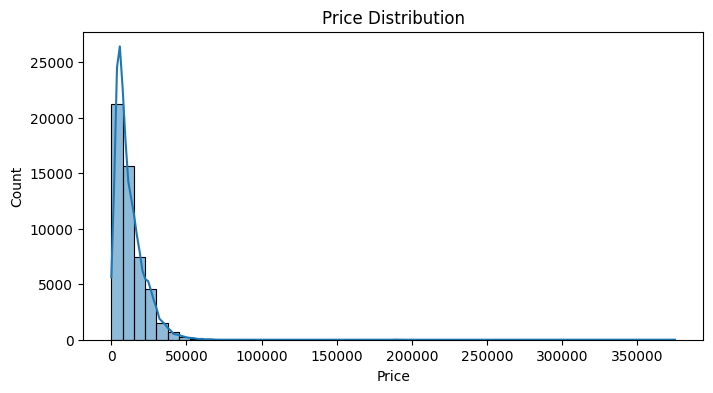

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


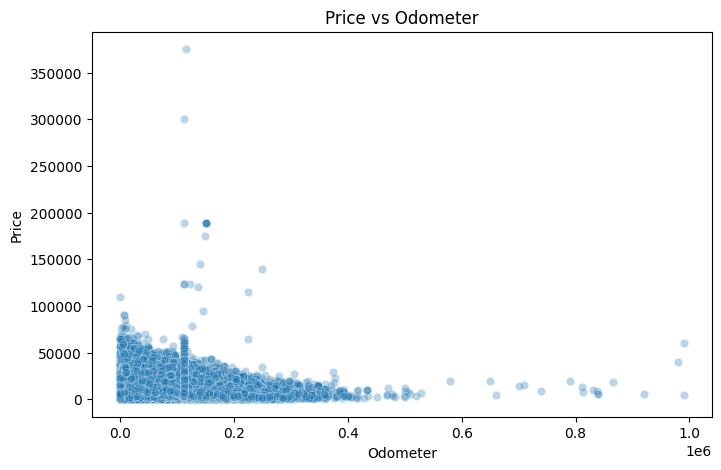

In [6]:
# Price vs Odometer
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['odometer'], y=df['price'], alpha=0.3)
plt.title('Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.show()


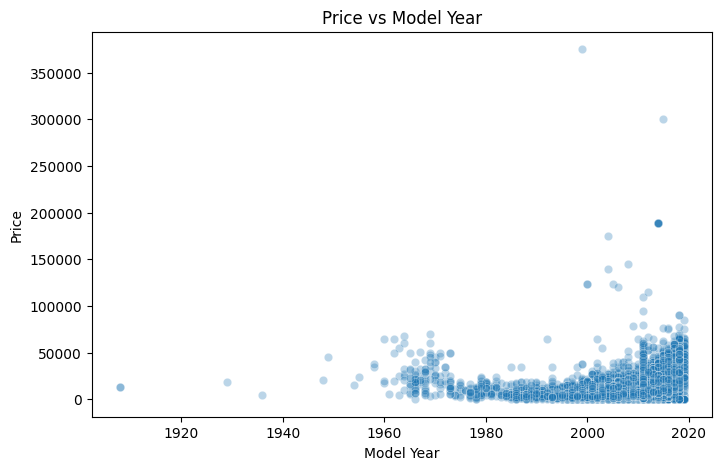

In [7]:
# Price vs Model Year
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['model_year'], y=df['price'], alpha=0.3)
plt.title('Price vs Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()


### EDA Summary

The exploratory analysis shows a strong inverse relationship between price and odometer, as well as a positive relationship between price and model year.  
These patterns confirm that mileage and vehicle age are key drivers of used car prices and should be prioritized during modeling.


## Feature Engineering

In this section, categorical features are encoded and numerical features are prepared for regression modeling.


In [8]:
# Define target and features
target = df['price']
features = df.drop('price', axis=1)

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include='object').columns
numerical_cols = features.select_dtypes(exclude='object').columns

categorical_cols, numerical_cols


(Index(['model', 'condition', 'fuel', 'transmission', 'type', 'paint_color',
        'date_posted'],
       dtype='object'),
 Index(['model_year', 'cylinders', 'odometer', 'is_4wd', 'days_listed'], dtype='object'))

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=42
)


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)


In [12]:
linreg_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)


In [13]:
# Train model
linreg_pipeline.fit(X_train, y_train)

# Predictions
y_pred = linreg_pipeline.predict(X_test)

# RMSE
rmse_lr = mean_squared_error(y_test, y_pred)**0.5
rmse_lr


7447.108003107999

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=120,
            max_depth=18,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rmse_rf = mean_squared_error(y_test, rf_pred) ** 0.5
rmse_rf



5592.6578259000025

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb_pipeline.fit(X_train, y_train)

gb_pred = gb_pipeline.predict(X_test)

rmse_gb = mean_squared_error(y_test, gb_pred) ** 0.5
rmse_gb



5972.814494637985

In [16]:
!pip install lightgbm


In [17]:
from lightgbm import LGBMRegressor


In [18]:
lgbm_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=-1,
            random_state=42
        ))
    ]
)


In [19]:
lgbm_pipeline.fit(X_train, y_train)

lgbm_pred = lgbm_pipeline.predict(X_test)

rmse_lgbm = mean_squared_error(y_test, lgbm_pred) ** 0.5
rmse_lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 38643, number of used features: 498
[LightGBM] [Info] Start training from score 12123.868618


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


5421.273092650863

After validation with 5-fold-cross-validation to ensure stable performance the result is 5421 meaning the model is working well.

In [21]:
from sklearn.model_selection import cross_val_score

# Cross-validation RMSE (negative MSE -> convert to RMSE)
cv_scores = cross_val_score(
    lgbm_pipeline,
    features,
    target,
    cv=5,
    scoring='neg_mean_squared_error'
)

rmse_cv = (-cv_scores.mean()) ** 0.5
rmse_cv


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 41220, number of used features: 497
[LightGBM] [Info] Start training from score 11967.058297


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 41220, number of used features: 498
[LightGBM] [Info] Start training from score 12249.556477


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 41220, number of used features: 497
[LightGBM] [Info] Start training from score 12169.065623


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 41220, number of used features: 497
[LightGBM] [Info] Start training from score 12100.485129


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1503
[LightGBM] [Info] Number of data points in the train set: 41220, number of used features: 497
[LightGBM] [Info] Start training from score 12176.159073


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


np.float64(5311.032442886132)

In [20]:
print("Linear Regression RMSE:", rmse_lr)
print("Random Forest RMSE:", rmse_rf)
print("LightGBM RMSE:", rmse_lgbm)


Linear Regression RMSE: 7447.108003107999
Random Forest RMSE: 5592.6578259000025
LightGBM RMSE: 5421.273092650863


## Model Comparison

The following models were evaluated using RMSE:

- Linear Regression
- Random Forest
- Gradient Boosting (sklearn)
- LightGBM

LightGBM achieved the lowest RMSE, making it the best performing model for this problem.


In [22]:
# Ensure model is fitted
lgbm_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
ohe = lgbm_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + list(numerical_cols)

# Extract feature importances
importances = lgbm_pipeline.named_steps['model'].feature_importances_

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

fi.head(15)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 38643, number of used features: 498
[LightGBM] [Info] Start training from score 12123.868618


,feature,importance
494,model_year,1647
496,odometer,1567
495,cylinders,528
498,days_listed,362
497,is_4wd,247
106,fuel_diesel,170
100,condition_excellent,139
127,paint_color_black,136
75,model_nissan frontier,120
102,condition_good,117


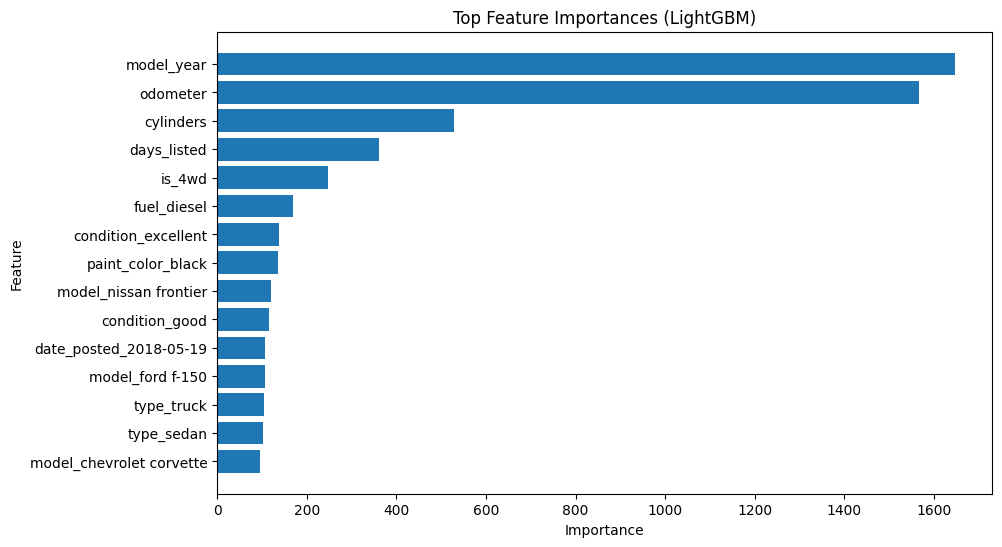

In [23]:
import matplotlib.pyplot as plt

top_n = 15
fi_top = fi.head(top_n).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(fi_top['feature'], fi_top['importance'])
plt.title('Top Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Feature Importance Summary

The model relies most heavily on vehicle age (model year), mileage (odometer), and specific vehicle attributes such as model, condition, and fuel type.  
These results align with real-world pricing logic: newer cars with lower mileage tend to be more expensive.


In [24]:
import re

def base_feature_name(feat: str) -> str:
    # Keep numeric features as they are
    if feat in numerical_cols:
        return feat

    # Special cases for categorical prefixes that contain underscores
    if feat.startswith('paint_color_'):
        return 'paint_color'
    if feat.startswith('date_posted_'):
        return 'date_posted'

    # Generic one-hot case: take text before first underscore
    return feat.split('_', 1)[0]

fi_grouped = fi.copy()
fi_grouped['base_feature'] = fi_grouped['feature'].apply(base_feature_name)

group_importance = (
    fi_grouped.groupby('base_feature', as_index=False)['importance']
    .sum()
    .sort_values('importance', ascending=False)
)

group_importance


,base_feature,importance
6,model,2576
7,model_year,1647
8,odometer,1567
1,cylinders,528
0,condition,485
2,date_posted,449
11,type,428
9,paint_color,387
3,days_listed,362
5,is_4wd,247


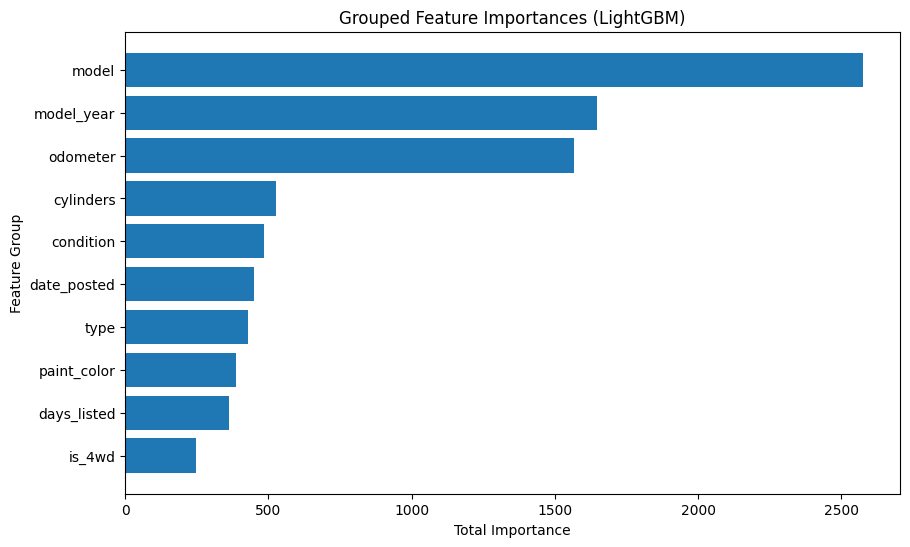

In [25]:
import matplotlib.pyplot as plt

top_n = 10
gi_top = group_importance.head(top_n).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(gi_top['base_feature'], gi_top['importance'])
plt.title('Grouped Feature Importances (LightGBM)')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.show()


## Final Business Conclusion


The objective of this project was to build a predictive model capable of estimating used vehicle prices based on their characteristics.

After evaluating multiple models, LightGBM achieved the best performance:

- Test RMSE: ~5,421
- Cross-Validation RMSE (5-fold): ~5,311

The close alignment between test and cross-validation performance indicates that the model generalizes well and is not overfitting.

Feature importance analysis revealed that the most influential factors in vehicle pricing are:

1. Vehicle model (brand and specific model)
2. Model year
3. Mileage (odometer reading)
4. Engine characteristics (cylinders)
5. Vehicle condition and type

These findings align with real-world market dynamics, where vehicle age, mileage, and specific model demand significantly impact pricing.

The final LightGBM model can support more accurate pricing strategies, helping the dealership remain competitive while minimizing pricing errors.
